# LDM prediction script

In [1]:
import os
import sys
import time
import math
import h5py
import logging
import warnings
import numpy as np
from glob import glob
from datetime import datetime, timedelta
from scipy.interpolate import RegularGridInterpolator

# supress regular warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.ERROR) 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# supress tensorflow warnings
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

# adjust for time step embedding layer
tf.config.run_functions_eagerly(True)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import model_utils as mu
import vae_utils as vu

In [4]:
def norm_precip(x):
    return np.log(x+1)

def norm_rh(x):
    return (x-50)/28/2

def norm_t(x):
    return (x-281)/10/2

def norm_u(x):
    return (x-3.5)/6.5/2

def norm_v(x):
    return (x)/6.5/2

def norm_pwat(x):
    return (x-20.5)/15/2

def norm_cape(x):
    return (x-200)/450/2

In [19]:
def reverse_diffuse(model, x_in1, x_in2, total_timesteps, gdf_util):
    L_valid = len(x_in1)
    x_out = np.empty(x_in1.shape)

    for i in range(L_valid):
        x1 = x_in1[i, ...][None, ...]
        x2 = x_in2[i, ...][None, ...]
        
        for t in reversed(range(0, total_timesteps)):
            tt = tf.cast(tf.fill(1, t), dtype=tf.int64)
            pred_noise = model.predict([x1, tt, x2], verbose=0)
            model_mean, _, model_log_variance =  gdf_util.p_mean_variance(pred_noise, x=x1, t=tt, clip_denoised=True)
            nonzero_mask = (1 - (np.array(tt)==0)).reshape((1, 1, 1, 1))
            x1 = np.array(model_mean) + nonzero_mask * np.exp(0.5 * np.array(model_log_variance)) * np.random.normal(size=x1.shape)
        x_out[i, ...] = x1

    return x_out

## Import LDM

In [6]:
total_timesteps = 50 # diffusion time steps
norm_groups = 8 # number of attention heads, number of layer normalization groups 

# min-max values of the diffusion target (learning target) 
clip_min = -1.0
clip_max = 1.0

input_shape = (32, 32, 8) # the tensor shape of reverse diffusion input
gfs_shape = (128, 128, 8) # the tensor shape of GFS embeddings

widths = [64, 96, 128, 256] # number of convolution kernels per up-/downsampling level
feature_sizes = [32, 16, 8, 4]

left_attention = [False, False, True, True] # True: use multi-head attnetion on each up-/downsampling level
right_attention = [False, False, True, True]
num_res_blocks = 2  # Number of residual blocks

F_y = 1/6.3 # the scale of VQ-VAE codes

N_atten1 = np.sum(left_attention)
N_atten2 = np.sum(right_attention)

load_weights = True # True: load previous weights
# location of the previous weights
model_name = '/glade/work/ksha/GAN/models/LDM_resize{}-{}_res{}_tune6/'.format(
    N_atten1, N_atten2, num_res_blocks)

# location for saving new weights
model_name_save = '/glade/work/ksha/GAN/models/LDM_resize{}-{}_res{}_tune6/'.format(
    N_atten1, N_atten2, num_res_blocks)

lr = 0

In [7]:
def build_model(input_shape, gfs_shape, widths, feature_sizes, left_attention, right_attention, num_res_blocks=2, norm_groups=8,
                interpolation='bilinear', activation_fn=keras.activations.swish,):

    first_conv_channels = widths[0]
    
    image_input = layers.Input(shape=input_shape, name="image_input")
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")
    gfs_input = layers.Input(shape=gfs_shape, name="gfs_input")
    
    x = layers.Conv2D(first_conv_channels, kernel_size=(3, 3), padding="same",
                      kernel_initializer=mu.kernel_init(1.0),)(image_input)

    temb = mu.TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = mu.TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)

    skips = [x]

    # DownBlock
    has_attention = left_attention
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = mu.ResidualBlock(widths[i], groups=norm_groups, activation_fn=activation_fn)([x, temb])
            
            if has_attention[i]:
                # GFS cross-attention inputs
                size_ = feature_sizes[i]
                x_gfs = gfs_input
                x_gfs = layers.Resizing(size_, size_, interpolation='bilinear')(x_gfs)

                x_gfs = layers.Conv2D(int(0.5*widths[i]), kernel_size=(3, 3), padding="same",)(x_gfs)
                x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
                x_gfs = activation_fn(x_gfs)

                x_gfs = layers.Conv2D(widths[i], kernel_size=(3, 3), padding="same",)(x_gfs)
                x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
                x_gfs = activation_fn(x_gfs)
                
                x = layers.MultiHeadAttention(num_heads=norm_groups, key_dim=widths[i])(x, x_gfs)
                
            skips.append(x)

        if widths[i] != widths[-1]:
            x = mu.DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = mu.ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)([x, temb])
    
    size_ = feature_sizes[-1]
    x_gfs = gfs_input
    x_gfs = layers.Resizing(size_, size_, interpolation='bilinear')(x_gfs)
    
    x_gfs = layers.Conv2D(int(0.5*widths[-1]), kernel_size=(3, 3), padding="same",)(x_gfs)
    x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
    x_gfs = activation_fn(x_gfs)

    x_gfs = layers.Conv2D(widths[-1], kernel_size=(3, 3), padding="same",)(x_gfs)
    x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
    x_gfs = activation_fn(x_gfs)
    
    x = layers.MultiHeadAttention(num_heads=norm_groups, key_dim=widths[-1])(x, x_gfs)
    
    x = mu.ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)([x, temb])

    # UpBlock
    has_attention = right_attention
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = mu.ResidualBlock(widths[i], groups=norm_groups, activation_fn=activation_fn)([x, temb])
            
            if has_attention[i]:
                
                # GFS cross-attention inputs
                size_ = feature_sizes[i]
                x_gfs = gfs_input
                x_gfs = layers.Resizing(size_, size_, interpolation='bilinear')(x_gfs)

                x_gfs = layers.Conv2D(int(0.5*widths[i]), kernel_size=(3, 3), padding="same",)(x_gfs)
                x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
                x_gfs = activation_fn(x_gfs)

                x_gfs = layers.Conv2D(widths[i], kernel_size=(3, 3), padding="same",)(x_gfs)
                x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
                x_gfs = activation_fn(x_gfs)
                
                x = layers.MultiHeadAttention(num_heads=norm_groups, key_dim=widths[i])(x, x_gfs)
                
        if i != 0:
            x = mu.UpSample(widths[i], interpolation=interpolation)(x)

    # End block
    x = layers.GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = layers.Conv2D(input_shape[-1], (3, 3), padding="same", kernel_initializer=mu.kernel_init(0.0))(x)
    return keras.Model([image_input, time_input, gfs_input], x, name="unet")


In [8]:
# Reverse diffusino model
model = build_model(input_shape=input_shape, gfs_shape=gfs_shape, widths=widths, 
                    feature_sizes=feature_sizes, left_attention=left_attention, right_attention=right_attention, 
                    num_res_blocks=num_res_blocks, norm_groups=norm_groups, activation_fn=keras.activations.swish)

# Compile the mdoel
model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=lr),)

# load previous weights
W_old = mu.dummy_loader(model_name)
model.set_weights(W_old)

## Import VQ-VAE

In [9]:
filter_nums = [64, 128] # number of convolution kernels per down-/upsampling layer 
latent_dim = 8 # number of latent feature channels
activation = 'relu' # activation function
num_embeddings = 128 # number of the VQ codes

input_size = (128, 128, 1) # size of MRMS input
latent_size = (32, 32, latent_dim) # size of compressed latent features

# location of the previous weights
model_name_load = '/glade/work/ksha/GAN/models/VQ_VAE_P128_{}_{}_L{}_N{}_{}_tune2'.format(
    filter_nums[0], filter_nums[1], latent_dim, num_embeddings, activation)
print('Loading {}'.format(model_name_load))

lr = 0 # learning rate

# ---------------- encoder ----------------- #
encoder_in = keras.Input(shape=input_size)
X = encoder_in

X = layers.Conv2D(filter_nums[0], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[0], activation)
X = mu.resblock_vqvae(X, 3, filter_nums[0], activation)

X = layers.Conv2D(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[1], activation)
X = mu.resblock_vqvae(X, 3, filter_nums[1], activation)

encoder_out = layers.Conv2D(latent_dim, 1, padding="same")(X)

# # --- VQ layer config --- #
vq_layer = vu.VectorQuantizer(num_embeddings, latent_dim)
X_VQ = vq_layer(encoder_out)
# # --- VQ layer config --- #

model_encoder_mrms = keras.Model(encoder_in, X_VQ)

# ---------------- decoder ----------------- #

decoder_in = keras.Input(shape=latent_size)

X = decoder_in

X = layers.Conv2D(filter_nums[1], 1, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2DTranspose(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[1], activation)
X = mu.resblock_vqvae(X, 3, filter_nums[1], activation)

X = layers.Conv2DTranspose(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.resblock_vqvae(X, 3, filter_nums[0], activation)
X = mu.resblock_vqvae(X, 3, filter_nums[0], activation)

decoder_out = layers.Conv2D(latent_dim, 1, padding="same")(X)

model_decoder_mrms = keras.Model(decoder_in, decoder_out)

# ---------------- VQ-VAE ------------------ #
IN = keras.Input(shape=input_size)
X = IN
X_VQ = model_encoder_mrms(X)
OUT = model_decoder_mrms(X_VQ)
model_vqvae = keras.Model(IN, OUT)

# subclass to VAE training
vqvae_trainer = vu.VQVAETrainer(model_vqvae, 1.0, latent_dim, num_embeddings)

# load weights
W_old = mu.dummy_loader(model_name_load)
vqvae_trainer.vqvae.set_weights(W_old)

# compile
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))

Loading /glade/work/ksha/GAN/models/VQ_VAE_P128_64_128_L8_N128_relu_tune2


## Data preparation

In [10]:
# configure the forward diffusion steps
gdf_util = mu.GaussianDiffusion(timesteps=total_timesteps)

In [11]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_01 = h5io['lon_01'][...]
    lat_01 = h5io['lat_01'][...]
    elev_01 = h5io['elev_01'][...]
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]

In [25]:
year = 2023
N_days = 365

ini = 6
lead = 3

day_start = 0
day_end = 1

N_ens = 10
thres_zero_mask = 0
thres_high_precip = norm_precip(10)

In [26]:
# data size info
x_mrms = 256; y_mrms = 576 # 0.1 deg MRMS size
x_gfs = 105; y_gfs = 242 # 0.25 deg GFS size

Nx_pred = 2
Ny_pred = 5
Ny_gap = 12
size_pred = 128

base = datetime(year, 1, 1)
date_list = [base + timedelta(days=d) for d in range(N_days)]

# ------- file locations and names ------ #
name_gfs = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_{}_ini{:02d}_f{:02d}.hdf'
name_apcp = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_APCP_{}_ini{:02d}_f{:02d}.hdf'
name_MRMS = '/glade/campaign/cisl/aiml/ksha/GFS/MRMS_y{}.hdf'

name_save = '/glade/campaign/cisl/aiml/ksha/LDM_results/LDM_day{:03d}_ini{:02d}_lead{:02d}.npy'

## Main prediction loop

In [27]:
T = 49

In [ ]:
# ------- Import data ------- #
with h5py.File(name_MRMS.format(year), 'r') as h5io:
    MRMS = h5io['MRMS'][...]
L_base = len(MRMS)
N_total = L_base

with h5py.File(name_gfs.format(year, ini, lead), 'r') as h5io:
    CAPE = h5io['CAPE'][...]
    PWAT = h5io['PWAT'][...]
    T800 = h5io['T800'][...]
    U800 = h5io['U800'][...]
    V800 = h5io['V800'][...]
    RH800 = h5io['RH800'][...]

with h5py.File(name_apcp.format(year, ini, lead), 'r') as h5io:
    APCP = h5io['APCP'][...]
    
for day in range(day_start, day_end, 1):
    
    # name_ = name_save .format(day, ini, lead)
    # if os.path.isfile(name_) is False:
        
    start_time = time.time()
    print('LDM prediction starts ...')
    N_hours = day*24 + ini + lead
    
    if N_hours < N_total:
        
        # ------- data allocations ------- #
        data = np.empty((1, x_mrms, y_mrms, 9))
        data[...] = np.nan
        
        gfs = np.empty((1, x_gfs, y_gfs, 7))
        gfs[...] = np.nan
        
        MRMS_pred = np.empty((N_ens, Nx_pred*Ny_pred, size_pred, size_pred,)); MRMS_pred[...] = np.nan
        MRMS_true = np.empty((Nx_pred*Ny_pred, size_pred, size_pred,)); MRMS_true[...] = np.nan
        APCP_true = np.empty((Nx_pred*Ny_pred, size_pred, size_pred,)); APCP_true[...] = np.nan
    
        # ----- data pre-processing ----- #
        
        MRMS_temp = MRMS[N_hours, ...] + MRMS[N_hours-1, ...] + MRMS[N_hours-2, ...]
        # if MRMS has no NaNs
        if np.sum(np.isnan(MRMS_temp)) == 0:
            
            gfs[..., 0] = APCP[day, ...]
            gfs[..., 1] = CAPE[day, ...]
            gfs[..., 2] = PWAT[day, ...]
            gfs[..., 3] = T800[day, ...]
            gfs[..., 4] = U800[day, ...]
            gfs[..., 5] = V800[day, ...]
            gfs[..., 6] = RH800[day, ...]
    
            data[..., 0] = MRMS_temp
    
            # index 1-7: GFS interpolated to 0.1 deg
            for i in range(7):
                lr_to_hr = RegularGridInterpolator((lat_GFS[:, 0], lon_GFS[0, :]), gfs[0, ..., i], 
                                                   bounds_error=False, fill_value=None)
                data[..., i+1] = lr_to_hr((lat_01, lon_01))
    
            # convert negative MRMS and APCP to zero
            # 
            temp = data[..., 0]
            temp[temp < 0] = 0
            data[..., 0] = temp
    
            temp = data[..., 1]
            temp[temp < 0] = 0
            data[..., 1] = temp
    
            # data normalization
            data[..., 0] = norm_precip(data[..., 0]) # MRMS
            data[..., 1] = norm_precip(data[..., 1]) # GFS APCCP
            data[..., 2] = norm_cape(data[..., 2]) # GFS CAPE
            data[..., 3] = norm_pwat(data[..., 3]) # PWAT
            data[..., 4] = norm_t(data[..., 4]) # T800
            data[..., 5] = norm_u(data[..., 5]) # U800
            data[..., 6] = norm_v(data[..., 6]) # V800
            data[..., 7] = norm_rh(data[..., 7]) # RH800
    
            # index 8: elevation
            data[..., 8] = elev_01 # normalized elevatino
            count = 0

            for px in range(Nx_pred):
                for py in range(Ny_pred):
                    ix0 = size_pred*px
                    ix1 = ix0+size_pred
                    
                    if py < (Ny_pred-1):
                        iy0 = (size_pred-Ny_gap)*py
                        iy1 = iy0 + size_pred
                    else:
                        iy1 = y_mrms
                        iy0 = y_mrms - size_pred

                    # if MRMS is all-zeros, return all-zeros directly
                    #gfs_ = data[:, ix0:ix1, iy0:iy1, 1]
                    mrms_ = data[:, ix0:ix1, iy0:iy1, 1]
                    flag_rain = np.sum(mrms_ > 1e-3) > thres_zero_mask
                    flag_heavy = np.max(mrms_) >= thres_high_precip
                    
                    if np.logical_or(flag_rain, flag_heavy):

                        # ---------- GFS embedding -------- #
                        #print('[{}:{}, {}:{}]'.format(ix0, ix1, iy0, iy1))
                        data_gfs_in = data[:, ix0:ix1, iy0:iy1, 1:]
                        lead_t = lead*np.ones(1,)
                        # GFS_latent = model_encoder_gfs.predict([data_gfs_in, lead_t], verbose=0)
                        # # re-scale for LDM (Fx = 0.1) 
                        # GFS_latent = F_x*GFS_latent
                        
                        # ---------- LDM prediction ------- #
                        # forward diffuse GFS APCP
                        Y_latent_APCP = model_encoder_mrms.predict(data[:, ix0:ix1, iy0:iy1, 1][..., None], verbose=0)
                        Y_latent_MRMS = model_encoder_mrms.predict(data[:, ix0:ix1, iy0:iy1, 0][..., None], verbose=0)
                        
                        # re-scale for LDM (Fy = 1/6.3)
                        Y_latent_APCP = F_y*Y_latent_APCP
                        Y_latent_MRMS = F_y*Y_latent_MRMS
                        
                        # diffusion steps
                        
                        t_diffuse_ = (T)*np.ones(1)
                        t_diffuse = t_diffuse_.astype(int)
                        
                        # --- ensemble ----- #
                        for n in range(N_ens):
                            # sample random noise
                            noise_ = np.random.normal(size=((1,)+input_shape))
                            forward_diffuse = np.array(gdf_util.q_sample(Y_latent_APCP, t_diffuse, noise_))
            
                            # reverse diffusion
                            Y_pred = reverse_diffuse(model, forward_diffuse, data_gfs_in, T, gdf_util)
            
                            # scale back
                            Y_pred = Y_pred/F_y
                            
                            # -------- VQ-VAE decode -------- #
                            MRMS_pred_ = model_decoder_mrms.predict(Y_pred, verbose=0)
                            MRMS_pred[n, count, ...] = np.mean(MRMS_pred_[...], axis=-1)
                            
                        MRMS_true[count, ...] = data[:, ix0:ix1, iy0:iy1, 0]
                        APCP_true[count, ...] = data[:, ix0:ix1, iy0:iy1, 1]
                        count += 1

                        # if count > 0:
                        #     aergaeh
                        
                    else:
                        print("all-zero precip detected")
                        MRMS_pred[n, count, ...] = 0
                        MRMS_true[count, ...] = data[:, ix0:ix1, iy0:iy1, 0]
                        APCP_true[count, ...] = data[:, ix0:ix1, iy0:iy1, 1]
                        count += 1
                    
        else:
            # MRMS is NaN
            print("MRMS missing")
            
    # dict_save = {}
    # dict_save['MRMS_pred'] = MRMS_pred
    # dict_save['MRMS_true'] = MRMS_true
    # dict_save['APCP_true'] = APCP_true
    
    # print(name_)
    # np.save(name_, dict_save)
    print("--- %s seconds ---" % (time.time() - start_time))

LDM prediction starts ...


In [ ]:
MRMS_pred[MRMS_pred<0] = 0
MRMS_pred_eval = np.exp(MRMS_pred)-1
MRMS_true_eval = np.exp(MRMS_true)-1
APCP_true_eval = np.exp(APCP_true)-1

In [ ]:
for i in range(10):
    print(np.mean(np.abs(MRMS_pred_eval[i, ...]-MRMS_true)))

In [17]:
for i in range(10):
    print(np.mean(np.abs(MRMS_pred_eval[i, ...]-MRMS_true)))

0.23288242040216814
0.21545454398944303
0.215342066724839
0.21667871310217005
0.22526013576618675
0.1934665285313927
0.2422962883595682
0.19321671027399867
0.21745897217547214
0.19955243659418387


In [18]:
np.mean(np.abs(APCP_true_eval-MRMS_true_eval))

0.37541309535375433

In [ ]:
i_pick = 1

fig, AX = plt.subplots(2, 3, figsize=(13, 8), sharex=True, sharey=True)

AX[0][0].pcolormesh(MRMS_true_eval[i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[0][1].pcolormesh(APCP_true_eval[i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)

AX[0][2].pcolormesh(MRMS_pred_eval[0, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][0].pcolormesh(MRMS_pred_eval[1, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][1].pcolormesh(MRMS_pred_eval[2, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][2].pcolormesh(MRMS_pred_eval[3, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)

plt.tight_layout()

In [ ]:
i_pick = 4

fig, AX = plt.subplots(2, 3, figsize=(13, 8), sharex=True, sharey=True)

AX[0][0].pcolormesh(MRMS_true_eval[i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[0][1].pcolormesh(APCP_true_eval[i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)

AX[0][2].pcolormesh(MRMS_pred_eval[0, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][0].pcolormesh(MRMS_pred_eval[1, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][1].pcolormesh(MRMS_pred_eval[2, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][2].pcolormesh(MRMS_pred_eval[3, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)

plt.tight_layout()

In [ ]:
i_pick = 9

fig, AX = plt.subplots(2, 3, figsize=(13, 8), sharex=True, sharey=True)

AX[0][0].pcolormesh(MRMS_true_eval[i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[0][1].pcolormesh(APCP_true_eval[i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)

AX[0][2].pcolormesh(MRMS_pred_eval[0, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][0].pcolormesh(MRMS_pred_eval[1, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][1].pcolormesh(MRMS_pred_eval[2, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][2].pcolormesh(MRMS_pred_eval[3, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)

plt.tight_layout()

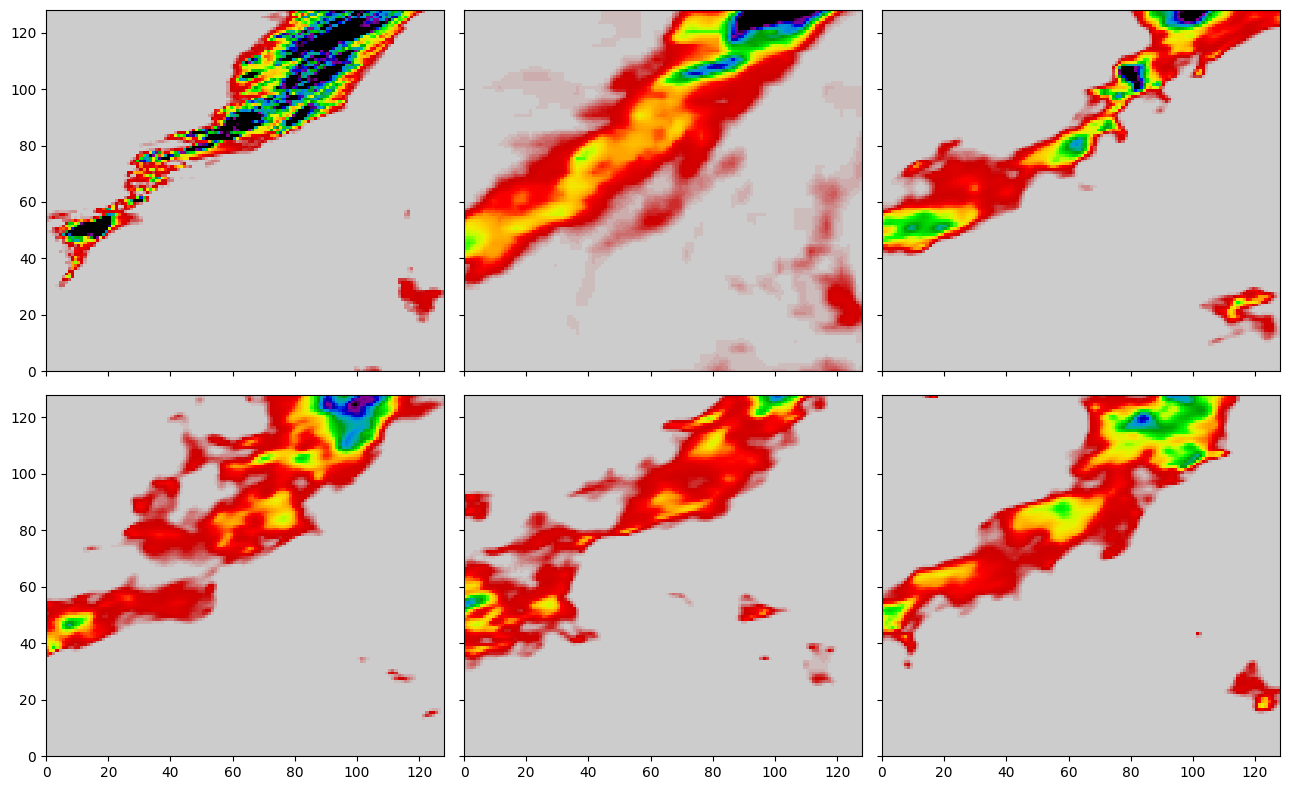

In [23]:
i_pick = 4

fig, AX = plt.subplots(2, 3, figsize=(13, 8), sharex=True, sharey=True)

AX[0][0].pcolormesh(MRMS_true_eval[i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[0][1].pcolormesh(APCP_true_eval[i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)

AX[0][2].pcolormesh(MRMS_pred_eval[0, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][0].pcolormesh(MRMS_pred_eval[1, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][1].pcolormesh(MRMS_pred_eval[2, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][2].pcolormesh(MRMS_pred_eval[3, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)

plt.tight_layout()

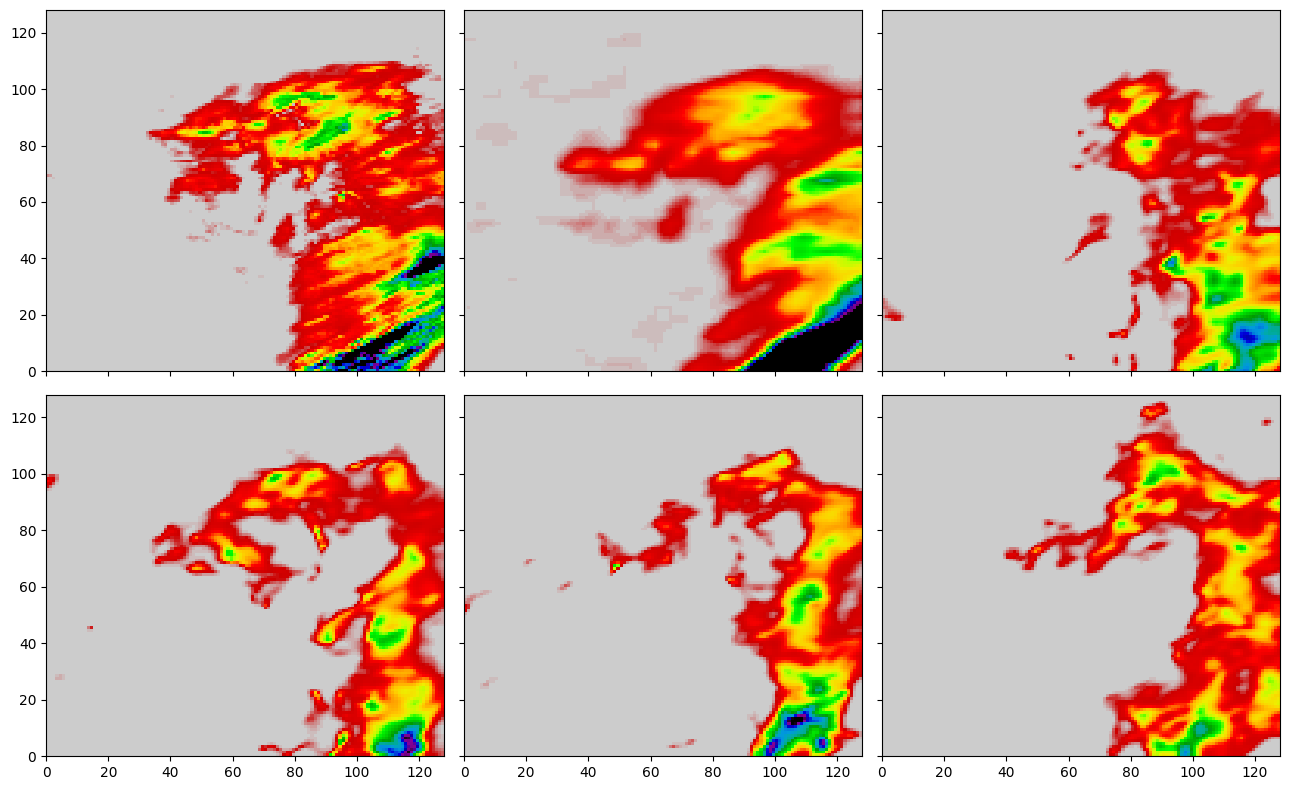

In [19]:
i_pick = 9

fig, AX = plt.subplots(2, 3, figsize=(13, 8), sharex=True, sharey=True)

AX[0][0].pcolormesh(MRMS_true_eval[i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[0][1].pcolormesh(APCP_true_eval[i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)

AX[0][2].pcolormesh(MRMS_pred_eval[0, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][0].pcolormesh(MRMS_pred_eval[1, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][1].pcolormesh(MRMS_pred_eval[2, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)
AX[1][2].pcolormesh(MRMS_pred_eval[3, i_pick, ...], vmin=0, vmax=15, cmap=plt.cm.nipy_spectral_r)

plt.tight_layout()

## Verification test

**CRPS**

In [17]:
y_pred = MRMS_pred[:, 0, ...].reshape(10, 128*128)[None, ...]
y_true = MRMS_true[0, ...].reshape(128*128)[None, ...]

**Full domain verification**

In [34]:
# data size info
x_mrms = 256; y_mrms = 576 # 0.1 deg MRMS size
x_gfs = 105; y_gfs = 242 # 0.25 deg GFS size

Nx_pred = 2
Ny_pred = 5
Ny_gap = 12
size_pred = 128

MRMS_pred = np.exp(MRMS_pred) - 1
MRMS_true = np.exp(MRMS_true) - 1
APCP_true = np.exp(APCP_true) - 1

MRMS_pred_domain = np.empty((10, x_mrms, y_mrms)); MRMS_pred_domain[...] = np.nan
MRMS_true_domain = np.empty((x_mrms, y_mrms)); MRMS_true_domain[...] = np.nan
APCP_true_domain = np.empty((x_mrms, y_mrms)); APCP_true_domain[...] = np.nan

count = 0
for px in range(Nx_pred):
    for py in range(Ny_pred):
        ix0 = size_pred*px
        ix1 = ix0+size_pred
        
        if py < (Ny_pred-1):
            iy0 = (size_pred-Ny_gap)*py
            iy1 = iy0 + size_pred
        else:
            iy1 = y_mrms
            iy0 = y_mrms - size_pred

        MRMS_pred_domain[:, ix0:ix1, iy0:iy1] = MRMS_pred[:, count, :, :]
        MRMS_true_domain[ix0:ix1, iy0:iy1] = MRMS_true[count, :, :]
        APCP_true_domain[ix0:ix1, iy0:iy1] = APCP_true[count, :, :]
        count += 1

MRMS_pred_domain[np.isnan(MRMS_pred_domain)] = 0
MRMS_pred_domain[MRMS_pred_domain<0] = 0

**Reliability diagram test**

In [35]:
from sklearn.calibration import calibration_curve

In [36]:
Y_prob = MRMS_pred_domain > 10
Y_prob = np.mean(Y_prob, axis=0)
Y_true = MRMS_true_domain > 10

prob_true, prob_pred = calibration_curve(Y_true.ravel(), Y_prob.ravel(), n_bins=20)

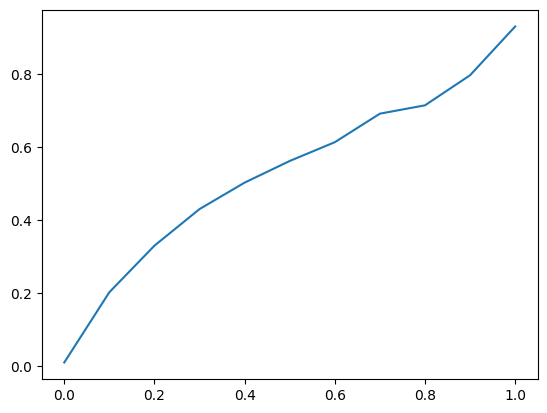

In [37]:
plt.plot(prob_pred, prob_true)

**Examples**